## 2.1 -  Implement K-means clustering from scratch

In [7]:
import numpy as np
import math
import cv2
import matplotlib.pyplot as plt

img = cv2.imread("flower.jpg", cv2.COLOR_BGR2RGB)
img = np.float32(img)


# 1. Randomly select K centers

# 2. Assign each point to the nearest cluster

# Compute new center (mean) for each cluster

def k_means(img, k, iter_n):
    """
    Segments the image
    -----
    args img: image to be segmented
    args k: number of clusters
    args iter: iteration numbers
    """
    height, width, ch = img.shape
    
    # 1. Randomly select K centers
    # We do this by create a random array of RGB or GRAY values for each K 
    centers = np.random.random_sample((k, ch))*255
    
    cluster_iter = []
    for i in range(iter_n):
        # 2. Assign each point to the nearest cluster
        # Arr shape = (K, height, width), where K is cluster group
        clusters = calc_distance(img, centers)
        cluster_iter.append(clusters)
        
        # 3. Compute new mean for each cluster 
        new_centers = np.empty(shape=(k, ch))
        for j in range(k):
            np.mean(img[clusters[0]==j], axis=0, out=new_centers[j])
            
        # If new centers and centers are the same, exit iteration
        if((centers == new_centers).all()):
            break
        else:
            centers = new_centers
            
    return cluster_iter
    
def calc_distance(points, centers):
    """
    Calculates the eucilidean distance between points and center
    -----
    args points: the points 
    args centers: the centers of the distributions
    """
    dists = []
    # Calculate the distance between each point and each center
    for center in centers:
        dists.append([img - center])
    dists = np.linalg.norm(dists, axis=-1)
    
    # Return closest center of each point
    return np.argmin(dists, axis=0)
   
def show_plot(imgs, cols=3, isGray = False):  
    for i in range(len(imgs)):
        plt.figure(figsize=(20, 4))
        if(i==5):
            plt.title("Final Iteration")
        else:
            plt.title("Iteration number: "+str(i))
        plt.axis('off')
        if(isGray):
            plt.imshow(clusters[i][0].astype(np.uint8), cmap='gray')
        else:
            plt.imshow(clusters[i][0].astype(np.uint8))
        plt.show()  
        
def show_figures(imgs, isGray = False, isEM = False):
    """
    Plots figures in groups of three
    -----
    args imgs: array of images to be shown
    args isGray: if cmap = gray or not, defaulted to false
    """
    length = len(imgs)
    arr = [131, 132, 133]
    
    j=0
    for i in range(len(imgs)):
        if(i%3==0):
            plt.figure(figsize=(10,10))
            j=0
        plt.subplot(arr[j])
        plt.xticks([]), plt.yticks([])
        
        if(isGray and not isEM):
            plt.imshow(imgs[i][0].astype(np.uint8), cmap='gray')
        elif(not isEM):
            plt.imshow(imgs[i][0].astype(np.uint8))
        elif(isGray and isEM):
            plt.imshow(imgs[i].astype(np.uint8), cmap='gray')
        else:
            plt.imshow(imgs[i][0].astype(np.uint8))
        
            
        j+=1
        if(i!=len(imgs)-1):
            plt.title("Iteration number: "+str(i))
            
    plt.title("Final Iteration")    
    plt.show()

### 2.1.1 - Applying K-means with K=2

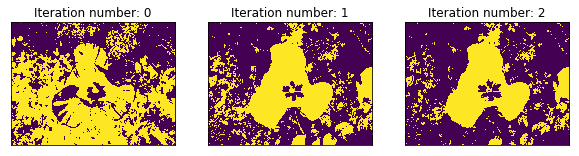

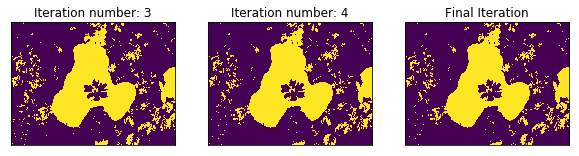

In [8]:
clusters = k_means(img, 2, 6)
#show_plot(clusters)
show_figures(clusters)

### 2.1.2 - Applying K-means with K=3

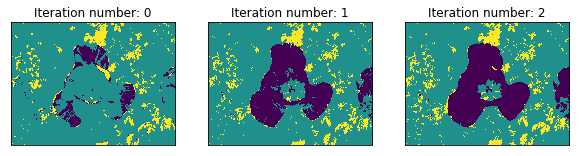

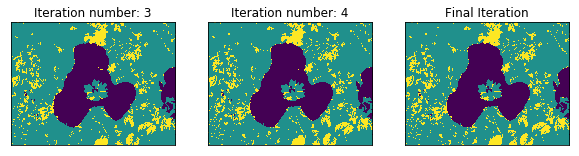

In [11]:
clusters = k_means(img, 3, 6)
show_figures(clusters)

### 2.1.3 - Applying K-means with grayscale and K=2

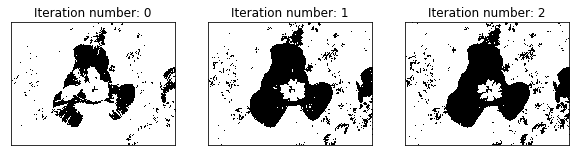

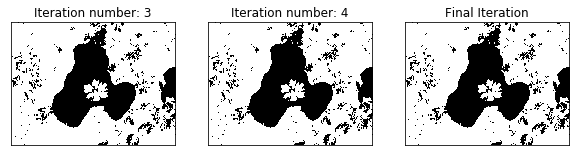

In [12]:
img_gray = cv2.imread("flower.jpg", cv2.COLOR_BGR2RGB)
img_gray = np.float32(img)
clusters = k_means(img_gray, 2, 6)
show_figures(clusters, isGray = True)

### 2.1.4 - Applying K-means with grayscale and K=3

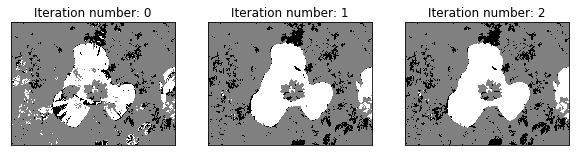

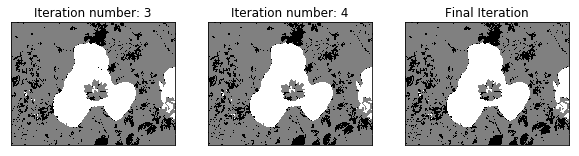

In [14]:
img_gray = cv2.imread("flower.jpg", cv2.COLOR_BGR2RGB)
img_gray = np.float32(img)
clusters = k_means(img_gray, 3, 6)
show_figures(clusters, isGray = True)

### 2.1.5 - Comparing segmenetation for color and gray-scale

In [7]:
# TODO : compare Color vs Gray scale


## 2.2 -  Implement EM-means clustering from scratch

In [15]:
import math

# prob(Pt | cluster i ) : Probability Density Function (PDF)
def prob_cluster(pixel, cent, std):
    """
    Calculate the probability of association between a point and a
    given Gaussian Distribution for each channel in a pixel.
    -----
    args pixel: the pixel. 
    args cent: the center of the Gaussian distribution. 
    args std: standard deviation OF Gaussian distribution. 
    -----
    returns: PDF of each gaussian K for one pixel. 
    """
    gauss_pdf = []
    for i in range(len(std)):
        point_pdf = []
        for j in range(len(pixel)):
            temp = 1/((math.sqrt(2*math.pi))*std[i][j]) * math.e**(-.5*math.pow((pixel[j]-cent[i][j])/std[i][j],2))
            point_pdf.append(temp)
        gauss_pdf.append(np.linalg.norm(point_pdf, axis=-1))  
    return gauss_pdf

def em(img, k, iterations=10):
    """
    Performs Expectation Maximization (EM) algorithm of an image 
    -----
    args img: the input image
    args k: the number of Gaussian Distributions
    args iterations: the number of iterations 
    -----
    """
    h, w, ch = img.shape
    
    if(k==1):
        raise Exception('K cannot be 1')
    
    # Randomly define a center for each K Gaussian components
    # This center will be the randomly initialized peak for the initial gaussian
    gaus_peak = np.random.random((k, ch)) * 255
    
    # Probability that a point is in a given gaussian K
    prob = np.full(k, (1/k))
    # STD of a point being in a given gaussian K
    std_gaus = np.full((k, ch), (255/k))

    iter_pdf = []
    for iter in range(iterations):
        # E-Step
        # Assign each point a probability of being in each K Gaussian
        pdf = np.empty(shape=(h, w, k))
        for row in range(h):
            for col in range(w):
                pdf[row][col] = prob_cluster(img[row][col], gaus_peak, std_gaus)
    
        # Normalize the distribution
        pixel_sum = np.sum(pdf * prob, axis=-1)
        pixel_sum = pixel_sum.reshape((h, w, 1))
        pdf = pdf / pixel_sum
    
        # Assign each pixel to a gaussian distribution
        cluster_groups = np.argmax(pdf, axis=-1)
        iter_pdf.append(cluster_groups)
        
        # M-Step
        # Recalculate the Gaussian Distributions with newly assigned points
        for distr in range(k):
            distr_sum = 0
            for i in range(h):
                for j in range(w):
                    distr_sum += pdf[i, j, distr] * img[i, j]
            
            gaus_peak[distr] = distr_sum / np.sum(pdf[:,:,distr])
            curr_cluster = img[cluster_groups==distr]
            std_gaus[distr] = np.sqrt(np.var(curr_cluster, axis=0))
            pdf[distr] = np.size(curr_cluster) / np.size(img)
    
    return iter_pdf

## 2.2.1 - Applying EM with K=2

In [17]:
img = cv2.imread("flower.jpg", cv2.COLOR_BGR2RGB)
img = np.float32(img)

em_gaussian2 = em(img, 2, 6)
#show_figures(em_gaussian2)

## 2.2.2 - Applying EM with K=3

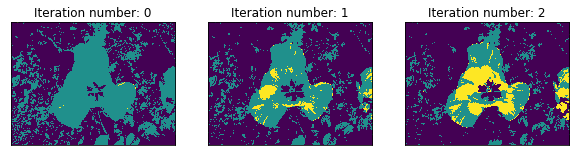

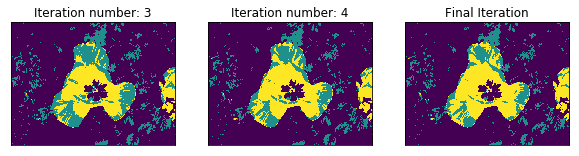

In [41]:
em_gaussian3 = em(img, 3, 6)
show_figures(em_gaussian3)

## 2.2.3 - Applying EM with Grayscale and K=2

In [ ]:
img_gray = cv2.imread("flower.jpg", cv2.COLOR_BGR2GRAY)
img_gray = np.float32(img_gray)

em_gray_2 = em(img_gray, 2, 6)
show_figures(em_gray_2)

## 2.2.4 - Applying EM with Grayscale and K=3 

In [ ]:
em_gray_3 = em(img_gray, 3, 6)
show_figures(em_gray_3)

In [ ]:
k = 2
ch = 3

# Gaus peaks (centers)
gaus_peak = np.random.random((k, ch)) * 255
# Probability that a point is in a given gaussian K
prob_gaus = np.full(k, (1/k))
# STD of a point being in a given gaussian K
std_gaus = np.full((k, ch), (255/k))

print("Probability Peaks", gaus_peak)
print("Probability Gaussian", prob_gaus)
print("STD Gaussian", std_gaus)

In [ ]:
k = 2

gaus_peaks = [[208.26710226, 235.0362611,  210.2826962],
              [62.51236031,  67.88919874, 207.86393764]]
PDF = [0.5, 0.5]
#STD = [[127.5, 127.5, 127.5],
        #[127.5, 127.5, 127.5]]
STD = [[100, 2, 3],
        [400, 5, 6]]
pixel = [32.3, 44.3, 59.2]

prob_cluster(pixel, gaus_peaks, STD)


In [ ]:
exp = [
        [[0.5, 0.6443], [0.3323, 0.322]], # 1st row
        [[0.63, 0.61], [0.22, 0.112]], # 2nd row
    ]
PDF = np.array([10, 1])

k = 2
h = 2
w = 2
tst = np.empty(shape=(h, w, k))

denom = np.sum(exp * PDF, axis=-1)
print(denom)
denom = denom.reshape((h, w, 1))
print(denom)
exp = exp / denom
print(exp)



#denom = denom.reshape((h, w, 1))
#exp = exp / denom

In [ ]:
gauss_pdf = []
    for j in range(len(pixel)):
        point_pdf = []
        for i in range(len(std)):
            print('pixel', pixel[j])
            print('STD',std[i][j])
            print('Center',cent[i][j])
            temp = 1/((math.sqrt(2*math.pi))*std[i][j]) * math.e**(-.5*math.pow((pixel[j]-cent[i][j])/std[i][j],2))
            point_pdf.append(temp)
    return point_pdf

In [ ]:
img = cv2.imread("flower.jpg", cv2.COLOR_BGR2RGB)
img = np.float32(img)

def show_plot(imgs):
    length = len(imgs)
    arr = [131, 132, 133]
    
    plt.figure(figsize=(10,10))
    j = 0
    for img in imgs:
        if(j%3==0):
            plt.figure(figsize=(10,10))
            j=0
        plt.subplot(arr[j])
        plt.imshow(img)
        j+=1
    plt.show()
    

imgs = []
for i in range(10):
    imgs.append(img)
    
show_plot(imgs)


In [ ]:
def k_means_data_points(data, k, iter_n):
    """
    Segments the image
    -----
    args img: image to be segmented
    args k: number of clusters
    args iter: iteration numbers
    """
    height, width = data.shape
    
    # 1. Randomly select K centers
    centers = np.random.random_sample((k, 2))*10

    cluster_iter = []
    for i in range(iter_n):
        # 2. Assign each point to the nearest cluster
        # Calculate distance between each point and each center
        distance = np.zeros((k, height))
        for i in range(0, height):
            for j in range(k):
                distance[j][i] = math.sqrt(
                    (centers[j][0] - data[i][0])**2 + (centers[j][1] - data[i][1])**2
                )

        # 2. Assign each point to the nearest cluster
        cluster = np.zeros(height)
        for i in range(len(distance[0])):
            if(distance[0][i] > distance[1][i]):
                cluster[i] = 0
            else:
                cluster[i] =1
        
        cluster_iter.append(cluster)

        # 3. and Compute new mean for each cluster 
        centers = compute_mean(cluster, height, k)

    return cluster_iter, centers

"""
Following code generates datapoints for question 1.1 part 3.
"""
data = np.float32(
    np.vstack((
        np.random.normal(
            loc = np.array([5,5]),
            scale = np.array([3,2]),
            size = (1000, 2)),
        np.random.normal(
            loc = np.array([-5, -5]),
            scale = np.array([5, 1]),
            size = (1000, 2)
        ))))
   
test, centers = k_means_data_points(data, k=2, iter_n=5)
test = test[4]

plt.figure(figsize=(10,5))
plt.subplot(121)
plt.plot(data[:,0], data[:,1],"ko")
plt.title("Data points")

plt.subplot(122)

red_x = []
red_y = []
blue_x = []
blue_y = []

for i in range(2000):
    if(test[i] == 0):
        red_x.append(data[i,0])
        red_y.append(data[i,1])
    elif(test[i] == 1):
        blue_x.append(data[i,0])
        blue_y.append(data[i,1]) 
    
plt.scatter(red_x, red_y, color='r')
plt.scatter(blue_x, blue_y, color='b')
plt.scatter((centers[0][0], centers[1][0]), (centers[0][1], centers[1][1]), s=80, color='y', marker='*')
plt.title("Data points - Labeled")
plt.show()

#em(data, k=2, iterations = 5)

#distance[j][i] = np.argmin(distance[], axis=0)
